<a href="https://colab.research.google.com/github/qkrdmswl/Data_Science/blob/main/COVID_19%EC%98%88%EC%B8%A1_prophet_inpyb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 원 출처
이 자료는 원 출처로부터 받은 inpyb파일을 변형시킨 파일입니다.
* [동영상:코로나 바이러스 확진자 수 예측하기](https://www.youtube.com/watch?v=y-oJYSoUNyI)
* [깃허브 소스코드 및 간략 설명](https://github.com/kairess/corona-virus-prediction)



---

* [설명 참고 블로그](https://jaejune0625.tistory.com/56)

# 라이브러리 불러오기

In [2]:
import pandas as pd
import plotly.graph_objs as go#깔끔한 그래프 라이브러리들 중 하나인 plotly
import plotly.offline as py#plotly를 오프라인에서 사용 가능하도록 함.(원래는 온라인에서 html로 그래프 출력)
from fbprophet import Prophet#페이스북에서 제공하는 예측 모델 라이브러리인 Prophet을 import함
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

import numpy as np

# 데이터셋 로드

error_bad_line 옵션을 False로 하면 오류가 발생한 줄을 빼고 처리함. 자세한 내용은 [링크](https://m.blog.naver.com/wideeyed/221743008492)참조

데이터셋 출처:[바로가기](https://github.com/jooeungen/coronaboard_kr)
* [kr_daily.csv](https://github.com/jooeungen/coronaboard_kr/blob/master/kr_daily.csv)를 사용했음
*이 레포지토리는 질병관리본부의 확진자 발표 후 매일 오전 11시에 업데이트됨

In [3]:
#원래 링크는 데이터의 정확도가 떨어지는 것 같아서 더 낫다고 판단되는 링크로 교체했습니다

'''
주의: 본 사이트에서 제공하는 통계 수치는 대한민국 질병관리 본부 및 세계 각국 관련 부처 보도자료, 국내외 언론 기사 등을 토대로 업데이트 되지만, 
개인이 취합한 내용이므로 수치의 정확성에 대해 책임질 수 없으며, 공식적인 근거 자료로 활용될 수 없습니다. 
본 사이트에서 제공하는 내용의 인용과 사용에 대한 책임은 전적으로 인용자 및 사용자에게 있음을 알립니다.
'''

url = 'https://raw.githubusercontent.com/jooeungen/coronaboard_kr/master/kr_daily.csv'
data = pd.read_csv(url, sep=',', error_bad_lines=False) #error_bad_line 옵션을 False로 하면 오류가 발생한 줄을 빼고 처리함.

#개인이 정부 공식 코로나 확진자 집계 발표 사이트를 바탕으로 데이터를 축적한 csv 파일입니다.
#지금까지는 매일매일 업데이트 되고 있습니다.

# Understanding the structure of the data set
# Data Set의 구조 파악

data.tail(10)

,date,confirmed,death,released,tested,negative,critical
466,20210501,122634,1831,112337,8883388,8675542,174.0
467,20210502,123240,1833,112865,8898234,8688387,170.0
468,20210503,123728,1834,113356,8915326,8702576,164.0
469,20210504,124269,1840,114128,8957155,8754790,162.0
470,20210505,124945,1847,114944,8994069,8790129,173.0
471,20210506,125519,1851,115491,9010992,8808418,172.0
472,20210507,126044,1860,116022,9051354,8846414,162.0
473,20210508,126745,1865,116881,9089166,8884162,165.0
474,20210509,127309,1874,117423,9105771,8897182,160.0
475,20210510,127772,1875,117844,9122059,8910889,161.0


###컬럼 설명
* confirmed:누적 코로나 확진자 수

* death:누적 코로나 확진 판정 후 사망자 수

* released:누적 격리해제된 사람들 수

* tested:누적 코로나 총 검사자 수*

* negative:누적 음성판정된 사람들 수

* critical:치명률

*총 검사자 = 검사 중 + 결과 음성 + 결과 확진

# 단순화(간략화) 작업

In [4]:
# 한국의 확진자 시계열 데이터프레임를 확인합니다

df_korea=data
df_korea['date']= df_korea['date'].astype('str')
df_korea['date']=pd.to_datetime(df_korea['date'])

 
df_korea.tail(100)

,date,confirmed,death,released,tested,negative,critical
376,2021-01-31,78198,1420,67878,5640818,5413070,229.0
377,2021-02-01,78503,1425,68309,5661842,5433883,225.0
378,2021-02-02,78839,1435,68775,5711413,5478309,224.0
379,2021-02-03,79306,1441,69299,5756714,5538559,220.0
380,2021-02-04,79757,1448,69704,5803095,5602800,211.0
...,...,...,...,...,...,...,...
471,2021-05-06,125519,1851,115491,9010992,8808418,172.0
472,2021-05-07,126044,1860,116022,9051354,8846414,162.0
473,2021-05-08,126745,1865,116881,9089166,8884162,165.0
474,2021-05-09,127309,1874,117423,9105771,8897182,160.0


In [5]:
#일일확진자 및 사망자 완치자 검사자 column생성
for df_korea_column in ["death","released","tested","confirmed"]:#사망자,격리해제자,검사자,확진자
  new_daily_column='daily_'+df_korea_column
  df_korea[new_daily_column]=df_korea[df_korea_column]
  for i in range(len(df_korea)):
    if i==0:
      df_korea[new_daily_column][i]=df_korea[df_korea_column][i]#첫번째 값을 계산할 땐 전날값이 없으므로(0이므로) 오늘값이 증가량임
    else:
      df_korea[new_daily_column][i]=df_korea[df_korea_column][i]-df_korea[df_korea_column][i-1]#오늘값-전날값=증가량

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:
df_korea.tail()

,date,confirmed,death,released,tested,negative,critical,daily_death,daily_released,daily_tested,daily_confirmed
471,2021-05-06,125519,1851,115491,9010992,8808418,172.0,4,547,16923,574
472,2021-05-07,126044,1860,116022,9051354,8846414,162.0,9,531,40362,525
473,2021-05-08,126745,1865,116881,9089166,8884162,165.0,5,859,37812,701
474,2021-05-09,127309,1874,117423,9105771,8897182,160.0,9,542,16605,564
475,2021-05-10,127772,1875,117844,9122059,8910889,161.0,1,421,16288,463


# 그래프 그리기

In [7]:
# Plot Korean COVID19 confirmed cases.
# 한국 코로나19 확진자 트렌드를 그래프로 만듭니다.
 
fig = go.Figure()
 
fig.add_trace( 
    go.Scatter(
        x=df_korea.date,
        y=df_korea.daily_confirmed,
        name='Confirmed in Korea'
    )
)
 
fig
#코로나 일일확진자수 그래프

# 페이스북에서 만든 Prophet라는 시계열 예측모델 사용
[Prophet 공식 홈페이지](https://facebook.github.io/prophet/)

<참고자료>

[Prophet 모델에 대한 간략 설명](https://hyperconnect.github.io/2020/03/09/prophet-package.html)

[Prophet을 이용한 주가 예측](https://skyeong.net/290)



In [19]:
weekends = pd.DataFrame({
    'holiday': 'weekends',
    'ds': pd.concat([
        pd.Series(pd.date_range('2020-01-25',df_prophet.at[len(df_prophet)-1,'ds'].date(), freq='7D')),
        pd.Series(pd.date_range('2020-01-26',df_prophet.at[len(df_prophet)-1,'ds'].date(), freq='7D'))
        ]).sort_index(axis=0),
    'lower_window': 0,
    'upper_window': 1,
})

In [20]:
# Make dataframe for Facebook Prophet prediction model.
# Facebook Prophet 예측 모델에 넣을 데이터프레임을 만들어줍니다.
df_prophet = df_korea.rename(columns={
    'date': 'ds',#날짜(ds)
    'daily_confirmed': 'y'#일일 확진자수를 y로 설정
})
#column명을 date에서 ds로, daily_confirmed에서 y로 바꿔줌 #.rename이 각 컬럼명을 일일히 바꿔줄 수 있는 함수임)
df_prophet.tail(10)

,ds,confirmed,death,released,tested,negative,critical,daily_death,daily_released,daily_tested,y
466,2021-05-01,122634,1831,112337,8883388,8675542,174.0,3,915,35096,627
467,2021-05-02,123240,1833,112865,8898234,8688387,170.0,2,528,14846,606
468,2021-05-03,123728,1834,113356,8915326,8702576,164.0,1,491,17092,488
469,2021-05-04,124269,1840,114128,8957155,8754790,162.0,6,772,41829,541
470,2021-05-05,124945,1847,114944,8994069,8790129,173.0,7,816,36914,676
471,2021-05-06,125519,1851,115491,9010992,8808418,172.0,4,547,16923,574
472,2021-05-07,126044,1860,116022,9051354,8846414,162.0,9,531,40362,525
473,2021-05-08,126745,1865,116881,9089166,8884162,165.0,5,859,37812,701
474,2021-05-09,127309,1874,117423,9105771,8897182,160.0,9,542,16605,564
475,2021-05-10,127772,1875,117844,9122059,8910889,161.0,1,421,16288,463


# 모델 만들기

# Add changepoints to Make More Flexible
# 예측을 더 유연하게 하기 위해 변곡점(changepoint) 추가
- https://facebook.github.io/prophet/docs/trend_changepoints.html

In [63]:
# Make Prophet model including daily seasonality
# Prophet에서 고려할 일일 계절성을 선택해서 모델을 만듭니다
m = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="additive",
    changepoint_prior_scale = 0.2, # default 0.05
    changepoint_range= 0.93, # 0.8
    holidays=weekends
)
m.add_seasonality(name='monthly_seasonality', period=30.5, fourier_order=5)
 
m.add_country_holidays(country_name='Korea')
m.upper_window=1.5 #holiday 이후 며칠동안 영향을 미치는가?
#m.lower_window=1 #holiday 전 며칠동안 영향을 미치는가?
 
 
#df_prophet를 예측모델에 피팅하기
m.fit(df_prophet)
##예측모델 만들기
future = m.make_future_dataframe(periods=21)#periods는 예측할 날짜의 수를 의미함
forecast = m.predict(future)#future의 데이터 프레임으로 예측하기
 
fig = plot_plotly(m, forecast,plot_cap=True,figsize=(1000, 800),trend=True, changepoints=False, xlabel='ds(확진자 증가량)', ylabel='y(시간)')#예측한 데이터 프레임을 그래프로 변환하기
py.iplot(fig)#그래프로 나타내기
#파란색 선이 예측값이고 하늘색 부분은 예측의 오차범위(?), 검정색 점 부분은 실제 데이터임
#하늘 색 부분이 정확히 뭔지는 추가 검색이 필요함

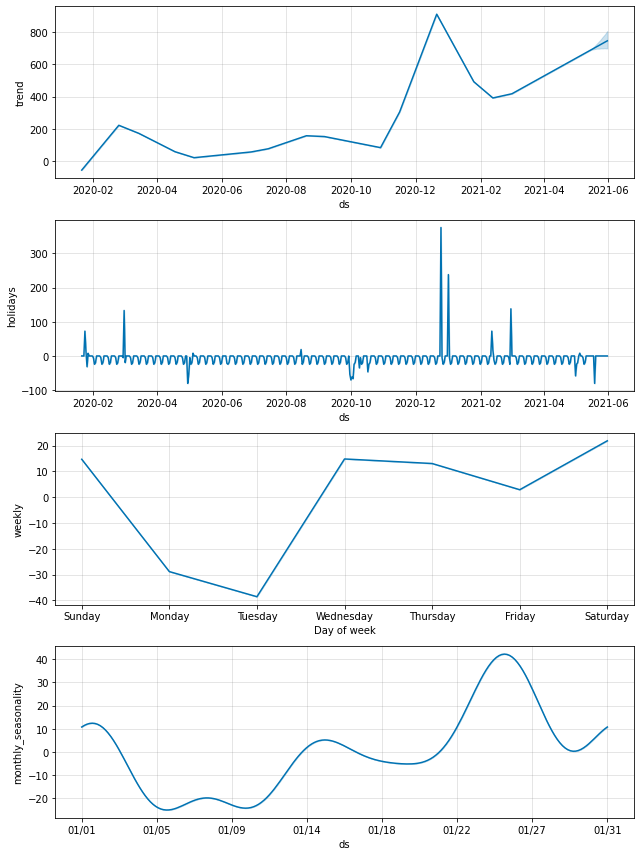

In [64]:
fig = m.plot_components(forecast)

In [65]:
forecast.T.index#forecast의 컬럼명

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Alternative holiday of Lunar New Year's Day',
       'Alternative holiday of Lunar New Year's Day_lower',
       'Alternative holiday of Lunar New Year's Day_upper',
       'Alternative public holiday', 'Alternative public holiday_lower',
       'Alternative public holiday_upper', 'Birthday of the Buddha',
       'Birthday of the Buddha_lower', 'Birthday of the Buddha_upper',
       'Children's Day', 'Children's Day_lower', 'Children's Day_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Chuseok', 'Chuseok_lower', 'Chuseok_upper', 'Hangeul Day',
       'Hangeul Day_lower', 'Hangeul Day_upper', 'Independence Movement Day',
       'Independence Movement Day_lower', 'Independence Movement Day_upper',
       'Labour Day', 'Labour Day_lower', 'Labour Day_upper', 'Liberation Day',
       'Liberation Day_lower', 'Liberation Day_upper', 'Lunar New Year's Day',
       'Lu

# Plot changepoints
# 변화점들(changepoints)이 시각화된 그래프

"\nfrom google.colab import files\nfig.savefig('output.pdf', format='pdf')\nfiles.download('output.pdf')\n"

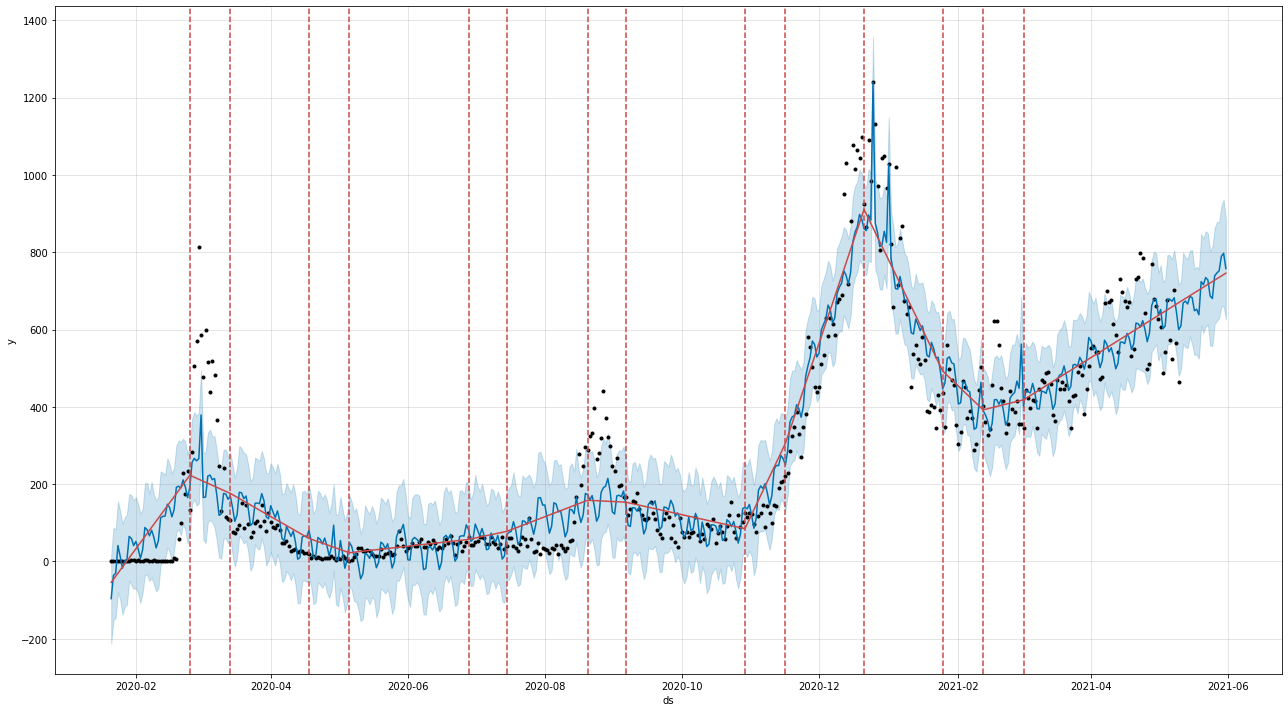

In [66]:
# display changepoints as red dotted line on the plot.
 
# changepoint를 그래프에 반영해봅시다.
fig = m.plot(forecast, figsize=(18, 10))
a = add_changepoints_to_plot(fig.gca(), m, forecast,cp_color='#cb4848')#cp_color=rgba hex or Matplotlib named color
 
#빨간색 점선 부분은 변곡(변화)이 발생한 부분이고 빨간색 실선은 추세(Trend)를 나타내는듯.
 
#그래프 파일 pdf로 다운 받기
'''
from google.colab import files
fig.savefig('output.pdf', format='pdf')
files.download('output.pdf')
'''

# 추세(트렌드)와 계절성 주기(패턴) 그래프


"\nfig2.savefig('trend_seasonality.pdf',format='pdf')\nfiles.download('trend_seasonality.pdf')\n"

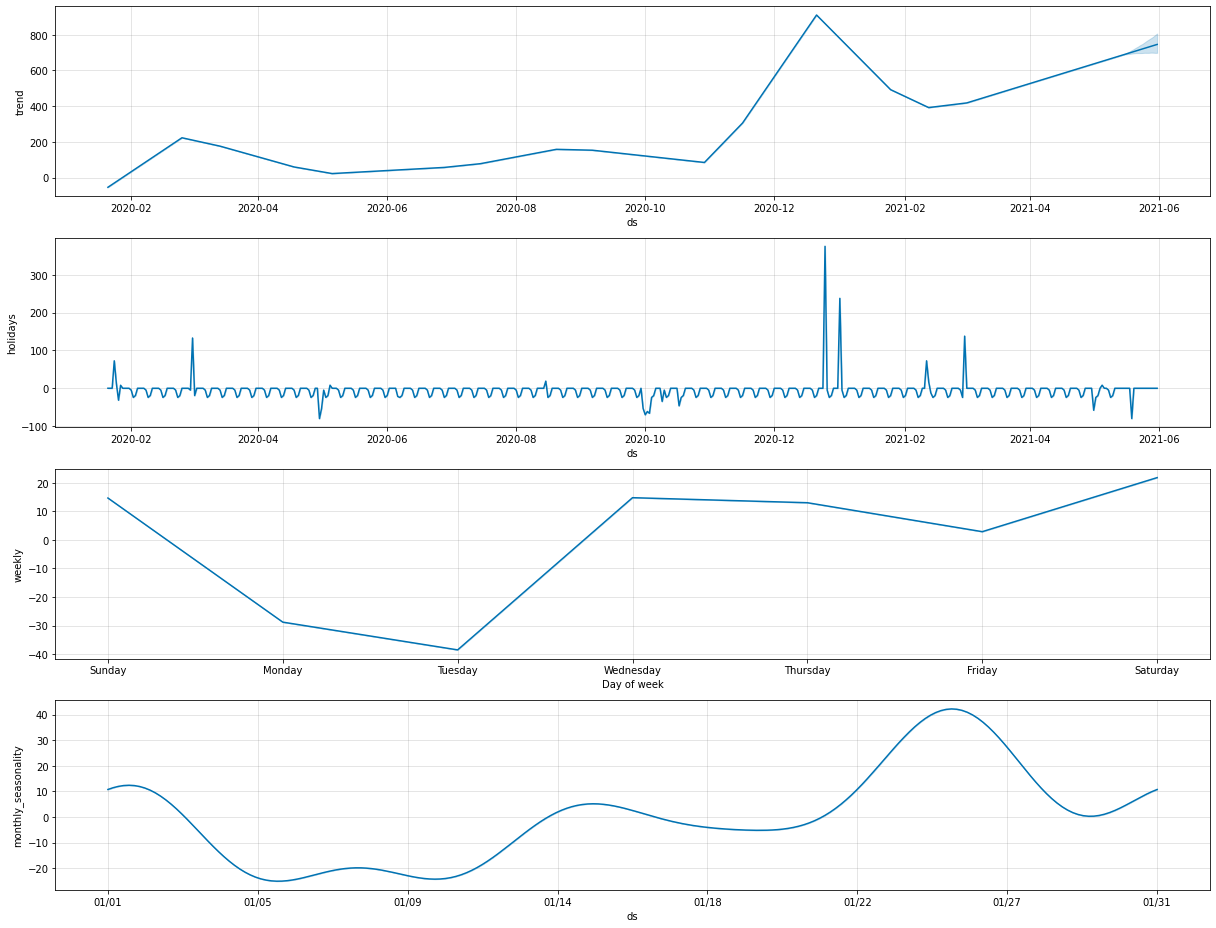

In [67]:
fig2 = m.plot_components(forecast, figsize=(17, 13))
#그래프 파일 pdf로 다운 받기
'''
fig2.savefig('trend_seasonality.pdf',format='pdf')
files.download('trend_seasonality.pdf')
'''

#한계점으로 생각되는것

데이터 변수를 하나밖에 고려하지 못하는 것 같음

(보류)

개인적으로 계절성과 주기, 추세의 정확한 의미를 아직 알지 못함..

=>그래서 모델의 예측능력이 떨어지는 것 같음.
모델의 특성을 정확히 파악하지 못하면 예측 능력이 기하급수적으로 하락



In [68]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, horizon = '118 days')

INFO:fbprophet:Making 1 forecasts with cutoffs between 2021-01-12 00:00:00 and 2021-01-12 00:00:00


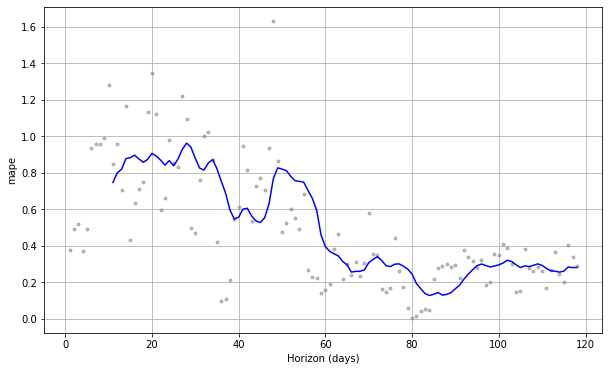

In [69]:
from fbprophet.plot import plot_cross_validation_metric
valid_fig = plot_cross_validation_metric(df_cv, metric='mape')